In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [2]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.window import Window

# scikit-learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from statsmodels.api import Logit
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

# others
import pandas as pd
import numpy as np
import sys
import itertools
import re
from random import sample
import time

In [ ]:
!pip install gensim

In [5]:
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
from gensim.models import Word2Vec

In [10]:
#create SparkSession
spark=SparkSession.builder.appName('seq_embedding').getOrCreate()

In [12]:
#reading a file
df = spark.read.csv('embedding_dataset.csv',header=True,inferSchema=True)

In [13]:
df.count()

1096955

In [12]:
df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- page: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- visit_number: integer (nullable = true)
 |-- time_spent: double (nullable = true)
 |-- converted: integer (nullable = true)



In [14]:
df.select('user_id').distinct().count()

104087

In [15]:
df.groupBy('page').count().orderBy('count',ascending=False).show(10,False)

+-------------+------+
|page         |count |
+-------------+------+
|product info |767131|
|homepage     |142456|
|added to cart|67087 |
|others       |39919 |
|offers       |32003 |
|buy          |24916 |
|reviews      |23443 |
+-------------+------+



In [16]:
df.select(['user_id','page','visit_number','time_spent','converted']).show(10,False)

+----------------------------------------------------------------+-------------+------------+-----------+---------+
|user_id                                                         |page         |visit_number|time_spent |converted|
+----------------------------------------------------------------+-------------+------------+-----------+---------+
|8057ed24427be18922f640b20b60997e7d070946b6c8f48117ae4d6dad0ebb23|homepage     |0           |0.16666667 |1        |
|8057ed24427be18922f640b20b60997e7d070946b6c8f48117ae4d6dad0ebb23|product info |0           |0.4        |1        |
|8057ed24427be18922f640b20b60997e7d070946b6c8f48117ae4d6dad0ebb23|product info |0           |0.31666666 |1        |
|8057ed24427be18922f640b20b60997e7d070946b6c8f48117ae4d6dad0ebb23|product info |0           |0.6333333  |1        |
|8057ed24427be18922f640b20b60997e7d070946b6c8f48117ae4d6dad0ebb23|product info |0           |0.15       |1        |
|8057ed24427be18922f640b20b60997e7d070946b6c8f48117ae4d6dad0ebb23|homepa

In [20]:
# window for each user order by timestamp
w = Window.partitionBy("user_id").orderBy('timestamp')

In [21]:
#creating a lagged column 
df = df.withColumn("previous_page", lag("page", 1, 'started').over(w))

In [23]:
df.select('user_id','timestamp','previous_page','page').show(10,False)

+----------------------------------------------------------------+-------------------+-------------+-------------+
|user_id                                                         |timestamp          |previous_page|page         |
+----------------------------------------------------------------+-------------------+-------------+-------------+
|004e96d0dc01f2541b7e5be735da6321b15f797ded220d5f6fb9d66910b5ce88|2017-04-10 20:23:09|started      |product info |
|004e96d0dc01f2541b7e5be735da6321b15f797ded220d5f6fb9d66910b5ce88|2017-04-10 20:26:23|product info |product info |
|004e96d0dc01f2541b7e5be735da6321b15f797ded220d5f6fb9d66910b5ce88|2017-04-12 14:12:40|product info |product info |
|004e96d0dc01f2541b7e5be735da6321b15f797ded220d5f6fb9d66910b5ce88|2017-04-12 20:49:33|product info |product info |
|004e96d0dc01f2541b7e5be735da6321b15f797ded220d5f6fb9d66910b5ce88|2017-04-13 12:18:12|product info |product info |
|01158797281955155c5c6bbe7daaa368021adcc4eaf4b3794e1789b5ee412a34|2018-02-21 23:

In [24]:
# adding an indicator if current page is same as next page
def indicator(page, prev_page):
    if page == prev_page:
        return 0
    else:
        return 1
    
page_udf = udf(indicator,IntegerType())

In [25]:
# adding a column for indicator and cumulative indicator
df = df.withColumn("indicator",page_udf(col('page'),col('previous_page'))) \
        .withColumn('indicator_cummulative',sum(col('indicator')).over(w))

In [27]:
df.select('previous_page','page','indicator','indicator_cummulative').show(20,False)

+-------------+-------------+---------+---------------------+
|previous_page|page         |indicator|indicator_cummulative|
+-------------+-------------+---------+---------------------+
|started      |product info |1        |1                    |
|product info |product info |0        |1                    |
|product info |product info |0        |1                    |
|product info |product info |0        |1                    |
|product info |product info |0        |1                    |
|started      |homepage     |1        |1                    |
|homepage     |homepage     |0        |1                    |
|homepage     |homepage     |0        |1                    |
|homepage     |homepage     |0        |1                    |
|homepage     |added to cart|1        |2                    |
|added to cart|homepage     |1        |3                    |
|homepage     |added to cart|1        |4                    |
|added to cart|homepage     |1        |5                    |
|started

In [28]:
# create window with user and indicator cummulative
w2 = Window.partitionBy(["user_id",'indicator_cummulative']).orderBy('timestamp')

In [29]:
# adding a column with time spent cumulative ( time spent by a user on a page  visited in continuation )
df = df.withColumn('time_spent_cummulative',sum(col('time_spent')).over(w2))

In [30]:
df.select('timestamp','previous_page','page','indicator','indicator_cummulative','time_spent','time_spent_cummulative').show(20,False)

+-------------------+-------------+-------------+---------+---------------------+-----------+----------------------+
|timestamp          |previous_page|page         |indicator|indicator_cummulative|time_spent |time_spent_cummulative|
+-------------------+-------------+-------------+---------+---------------------+-----------+----------------------+
|2017-04-10 20:23:09|started      |product info |1        |1                    |3.2333333  |3.2333333             |
|2017-04-10 20:26:23|product info |product info |0        |1                    |0.08       |3.3133333             |
|2017-04-12 14:12:40|product info |product info |0        |1                    |0.08       |3.3933333             |
|2017-04-12 20:49:33|product info |product info |0        |1                    |0.08       |3.4733333             |
|2017-04-13 12:18:12|product info |product info |0        |1                    |0.08       |3.5533333000000002    |
|2018-02-21 23:47:13|started      |homepage     |1        |1    

In [31]:
# creating a window to get final page and final timespent 
w3 = Window.partitionBy(["user_id",'indicator_cummulative']).orderBy(col('timestamp').desc())

In [32]:
# Add column for final page category and final time spent
df = df.withColumn('final_page',first('page').over(w3))\
     .withColumn('final_time_spent',first('time_spent_cummulative').over(w3))


In [34]:
df.select(['time_spent_cummulative','indicator_cummulative','page','final_page','final_time_spent']).show(10,False)

+----------------------+---------------------+-------------+-------------+-------------------+
|time_spent_cummulative|indicator_cummulative|page         |final_page   |final_time_spent   |
+----------------------+---------------------+-------------+-------------+-------------------+
|3.5533333000000002    |1                    |product info |product info |3.5533333000000002 |
|3.4733333             |1                    |product info |product info |3.5533333000000002 |
|3.3933333             |1                    |product info |product info |3.5533333000000002 |
|3.3133333             |1                    |product info |product info |3.5533333000000002 |
|3.2333333             |1                    |product info |product info |3.5533333000000002 |
|0.43333334999999995   |1                    |homepage     |homepage     |0.43333334999999995|
|0.30000001            |1                    |homepage     |homepage     |0.43333334999999995|
|0.23333334            |1                    |home

In [35]:
# user and pagelevel aggregation  
aggregations=[]
aggregations.append(max(col('final_page')).alias('page_emb'))
aggregations.append(max(col('final_time_spent')).alias('time_spent_emb'))
aggregations.append(max(col('converted')).alias('converted_emb'))

In [36]:
#selecting relevant columns
# extracting the dataframe with the data frame that will be used for embedding
df_embedding = df.select(['user_id','indicator_cummulative','final_page','final_time_spent','converted']).groupBy(['user_id','indicator_cummulative']).agg(*aggregations)

In [37]:
df_embedding.count()

414770

In [37]:
df_embedding.show(30, False)

+----------------------------------------------------------------+---------------------+-------------+-------------------+-------------+
|user_id                                                         |indicator_cummulative|page_emb     |time_spent_emb     |converted_emb|
+----------------------------------------------------------------+---------------------+-------------+-------------------+-------------+
|004e96d0dc01f2541b7e5be735da6321b15f797ded220d5f6fb9d66910b5ce88|1                    |product info |3.5533333000000002 |0            |
|01158797281955155c5c6bbe7daaa368021adcc4eaf4b3794e1789b5ee412a34|1                    |homepage     |0.43333334999999995|0            |
|01158797281955155c5c6bbe7daaa368021adcc4eaf4b3794e1789b5ee412a34|2                    |added to cart|0.11666667         |0            |
|01158797281955155c5c6bbe7daaa368021adcc4eaf4b3794e1789b5ee412a34|3                    |homepage     |0.05               |0            |
|01158797281955155c5c6bbe7daaa368021adcc4

In [38]:
# create a partition by user id ordered by indicator cumulative to get the journey
w4 = Window.partitionBy(["user_id"]).orderBy('indicator_cummulative')
w5 = Window.partitionBy(["user_id"]).orderBy(col('indicator_cummulative').desc())

In [39]:
df_embedding = df_embedding.withColumn('journey_page', collect_list(col('page_emb')).over(w4))\
                          .withColumn('journey_time_temp', collect_list(col('time_spent_emb')).over(w4)) \
                         .withColumn('journey_page_final',first('journey_page').over(w5))\
                        .withColumn('journey_time_final',first('journey_time_temp').over(w5)) \
                        .select(['user_id','journey_page_final','journey_time_final','converted_emb'])

In [40]:
df_embedding.select('user_id','journey_page_final','journey_time_final').show(10)

+--------------------+--------------------+--------------------+
|             user_id|  journey_page_final|  journey_time_final|
+--------------------+--------------------+--------------------+
|004e96d0dc01f2541...|      [product info]|[3.5533333000000002]|
|01158797281955155...|[homepage, added ...|[0.43333334999999...|
|01158797281955155...|[homepage, added ...|[0.43333334999999...|
|01158797281955155...|[homepage, added ...|[0.43333334999999...|
|01158797281955155...|[homepage, added ...|[0.43333334999999...|
|01158797281955155...|[homepage, added ...|[0.43333334999999...|
|020d29467c7810a85...|[homepage, produc...|  [0.25, 1.03333334]|
|020d29467c7810a85...|[homepage, produc...|  [0.25, 1.03333334]|
|032d6e8c20f41c18e...|      [product info]|       [2.329999975]|
|0377ebcf2ac8f8aef...|      [product info]|[1.0699999999999998]|
+--------------------+--------------------+--------------------+
only showing top 10 rows



In [43]:
df_embedding.count()

414770

In [44]:
df_embedding.select('user_id').distinct().count()

104087

In [41]:
df_embedding = df_embedding.dropDuplicates()

In [42]:
df_embedding.count()

104087

In [43]:
df_embedding.select('user_id').distinct().count()

104087

In [44]:
df_embedding.select('user_id','journey_page_final','journey_time_final').show(10)

+--------------------+--------------------+--------------------+
|             user_id|  journey_page_final|  journey_time_final|
+--------------------+--------------------+--------------------+
|004e96d0dc01f2541...|      [product info]|[3.5533333000000002]|
|01158797281955155...|[homepage, added ...|[0.43333334999999...|
|020d29467c7810a85...|[homepage, produc...|  [0.25, 1.03333334]|
|032d6e8c20f41c18e...|      [product info]|       [2.329999975]|
|0377ebcf2ac8f8aef...|      [product info]|[1.0699999999999998]|
|03f484c3d0dc5afaf...|[homepage, produc...|[0.65000001000000...|
|040828e6773148d00...|      [product info]|       [1.430000006]|
|05bd9a73b6f61509e...|      [product info]|       [14.79999967]|
|068ea915e886eb11c...|[homepage, others...|[0.5, 0.5, 0.9799...|
|06a572f2d5e9d5c56...|      [product info]|              [0.56]|
+--------------------+--------------------+--------------------+
only showing top 10 rows



In [45]:
# create pandas dataframe for embedding
pd_df_embedding = df_embedding.toPandas()

In [46]:
pd_df_embedding.head(5)

,user_id,journey_page_final,journey_time_final,converted_emb
0,004e96d0dc01f2541b7e5be735da6321b15f797ded220d...,[product info],[3.5533333000000002],0
1,01158797281955155c5c6bbe7daaa368021adcc4eaf4b3...,"[homepage, added to cart, homepage, added to c...","[0.43333334999999995, 0.11666667, 0.05, 0.0833...",0
2,020d29467c7810a85cdf9c85f8bad4c551bc79f5aee959...,"[homepage, product info]","[0.25, 1.03333334]",0
3,032d6e8c20f41c18ec32b4178099e5ec6648715cb43953...,[product info],[2.329999975],0
4,0377ebcf2ac8f8aef0f6dc28d61479f85a30d88203b9a4...,[product info],[1.0699999999999998],0


In [55]:
# making sure we don't have journeys with length less than 4
pd_df_embedding = pd_df_embedding[pd_df_embedding['journey_length'] > 4 ]

In [47]:
# reset index
pd_df_embedding = pd_df_embedding.reset_index(drop=True)

In [48]:
# train model
EMBEDDING_SIZE = 100
model = Word2Vec(pd_df_embedding['journey_page_final'], size=EMBEDDING_SIZE)

In [49]:
model.total_train_time

0.7907839000254171

In [51]:
# summarize the loaded model
print(model)

Word2Vec(vocab=7, size=100, alpha=0.025)


In [52]:
# summarize vocabulary
page_categories = list(model.wv.vocab)

In [53]:
# page categories 
print(page_categories)

['product info', 'homepage', 'added to cart', 'others', 'reviews', 'offers', 'buy']


In [54]:
# sample embedding
print(model['reviews'])

[ 0.47489035  0.53834176 -0.47785276 -0.26488945 -0.2656599  -0.04322785
  0.24362227  0.26430744 -0.48902759 -0.31393662  0.41263634  0.78189737
  0.58100605 -0.4459599  -0.70117044 -0.63221812 -0.6908192  -0.6791628
 -0.02506013  0.21131983 -0.02721698 -0.20559131 -0.78862274 -0.55389541
 -0.1507041   0.7149269  -0.24301411  0.29431018 -0.52848756 -0.500494
  0.16006927 -0.10355954 -0.36789769 -0.01349463 -0.40723842  0.15346751
 -0.79262614 -0.67456675 -0.18617149  0.69221032  0.53981733  0.75779319
  0.0573662   0.85435468  0.78063792  0.57342744 -0.16319969  0.46502107
 -0.09518502  0.60525858  0.31979162 -0.26889852 -0.12189896  0.65022558
  0.07857032  0.06138223  0.15626955  0.23680885  0.33999926 -0.54703128
 -0.21992962  0.83436728 -0.34557605 -0.69831383  0.4595826  -0.49346444
 -0.14114673  0.37797749  0.70894194  0.55426389 -0.40428343 -0.67311144
 -0.46010655 -0.44518954  0.7340765  -0.04775194 -0.44416061  0.45019379
 -0.54332632 -0.48565596  0.093257   -0.5141685   0.24

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [55]:
# embedding shape 
model['offers'].shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(100,)

In [56]:
# capturing embedding matrix
X = model[model.wv.vocab]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [57]:
# embedding matrix shapee
X.shape

(7, 100)

In [58]:
# run PCA with 2 compopnent to visualize page category embedding
pca = PCA(n_components=2)
result = pca.fit_transform(X)

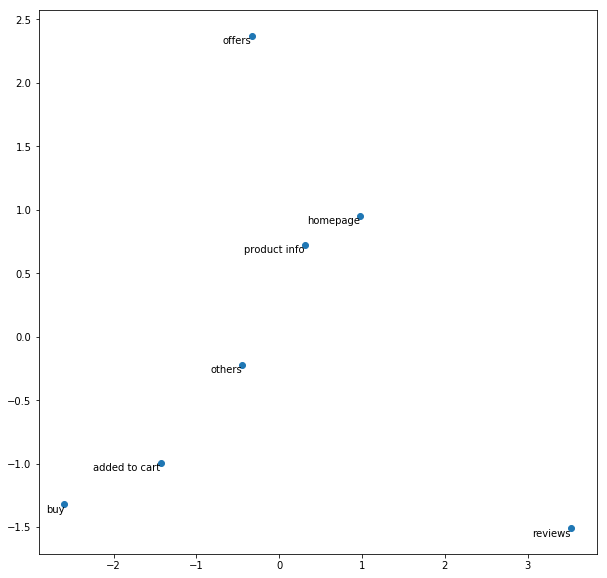

In [59]:
# plotting with page-categories
# create a scatter plot of the projection
plt.figure(figsize=(10,10))
plt.scatter(result[:, 0], result[:, 1])

for i,page_category in enumerate(page_categories):
    plt.annotate(page_category,horizontalalignment='right', verticalalignment='top',xy=(result[i, 0], result[i, 1]))

plt.show()